In [1]:
####

In [81]:
import torch
from torch import nn
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import transforms
from tqdm.notebook import tqdm
import math

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [93]:
def iou(bboxes1 , bboxes2):
    area1 = (bboxes1[..., 2] - bboxes1[..., 0]) * (bboxes1[..., 3] - bboxes1[..., 1])
    area2 = (bboxes2[..., 2] - bboxes2[..., 0]) * (bboxes2[..., 3] - bboxes2[..., 1])
    inter_max_xy = torch.min(bboxes1[..., 2:],bboxes2[..., 2:])
    inter_min_xy = torch.max(bboxes1[..., :2],bboxes2[..., :2])
    #print(inter_max_xy.shape , inter_min_xy.shape)
    inter = torch.clamp((inter_max_xy - inter_min_xy), min=0)
    inter_area = inter[..., 0] * inter[..., 1]
    union = area1+area2-inter_area
    ious = inter_area / union
    ious = torch.clamp(ious,min=0,max = 1.0)
    return ious

In [70]:
def giou(bboxes1 , bboxes2):
    area1 = (bboxes1[..., 2] - bboxes1[..., 0]) * (bboxes1[..., 3] - bboxes1[..., 1])
    area2 = (bboxes2[..., 2] - bboxes2[..., 0]) * (bboxes2[..., 3] - bboxes2[..., 1])
    inter_max_xy = torch.min(bboxes1[..., 2:],bboxes2[..., 2:])
    inter_min_xy = torch.max(bboxes1[..., :2],bboxes2[..., :2])
    out_max_xy = torch.max(bboxes1[..., 2:],bboxes2[..., 2:])
    out_min_xy = torch.min(bboxes1[..., :2],bboxes2[..., :2])
    inter = torch.clamp((inter_max_xy - inter_min_xy), min=0)
    inter_area = inter[..., 0] * inter[..., 1]
    outer = torch.clamp((out_max_xy - out_min_xy), min=0)
    outer_area = outer[..., 0] * outer[..., 1]
    union = area1+area2-inter_area
    closure = outer_area
    ious = inter_area / union - (closure - union) / closure
    ious = torch.clamp(ious,min=-1.0,max = 1.0)
    return ious

In [74]:
def diou(bboxes1 , bboxes2):
    w1 = bboxes1[..., 2] - bboxes1[..., 0]
    h1 = bboxes1[..., 3] - bboxes1[..., 1]
    w2 = bboxes2[..., 2] - bboxes2[..., 0]
    h2 = bboxes2[..., 3] - bboxes2[..., 1]

    area1 = w1 * h1
    area2 = w2 * h2
    center_x1 = (bboxes1[..., 2] + bboxes1[..., 0]) / 2
    center_y1 = (bboxes1[..., 3] + bboxes1[..., 1]) / 2
    center_x2 = (bboxes2[..., 2] + bboxes2[..., 0]) / 2
    center_y2 = (bboxes2[..., 3] + bboxes2[..., 1]) / 2

    inter_max_xy = torch.min(bboxes1[..., 2:],bboxes2[..., 2:])
    inter_min_xy = torch.max(bboxes1[..., :2],bboxes2[..., :2])
    out_max_xy = torch.max(bboxes1[..., 2:],bboxes2[..., 2:])
    out_min_xy = torch.min(bboxes1[..., :2],bboxes2[..., :2])

    inter = torch.clamp((inter_max_xy - inter_min_xy), min=0)
    inter_area = inter[..., 0] * inter[..., 1]
    inter_diag = (center_x2 - center_x1)**2 + (center_y2 - center_y1)**2
    outer = torch.clamp((out_max_xy - out_min_xy), min=0)
    outer_diag = (outer[..., 0] ** 2) + (outer[..., 1] ** 2)
    union = area1+area2-inter_area
    dious = inter_area / union - (inter_diag) / outer_diag
    dious = torch.clamp(dious,min=-1.0,max = 1.0)
    return dious

In [75]:
def ciou(bboxes1 , bboxes2):
    w1 = bboxes1[..., 2] - bboxes1[..., 0]
    h1 = bboxes1[..., 3] - bboxes1[..., 1]
    w2 = bboxes2[..., 2] - bboxes2[..., 0]
    h2 = bboxes2[..., 3] - bboxes2[..., 1]

    area1 = w1 * h1
    area2 = w2 * h2

    center_x1 = (bboxes1[..., 2] + bboxes1[..., 0]) / 2
    center_y1 = (bboxes1[..., 3] + bboxes1[..., 1]) / 2
    center_x2 = (bboxes2[..., 2] + bboxes2[..., 0]) / 2
    center_y2 = (bboxes2[..., 3] + bboxes2[..., 1]) / 2

    inter_max_xy = torch.min(bboxes1[..., 2:],bboxes2[..., 2:])
    inter_min_xy = torch.max(bboxes1[..., :2],bboxes2[..., :2])
    out_max_xy = torch.max(bboxes1[..., 2:],bboxes2[..., 2:])
    out_min_xy = torch.min(bboxes1[..., :2],bboxes2[..., :2])

    inter = torch.clamp((inter_max_xy - inter_min_xy), min=0)
    inter_area = inter[..., 0] * inter[..., 1]
    inter_diag = (center_x2 - center_x1)**2 + (center_y2 - center_y1)**2
    outer = torch.clamp((out_max_xy - out_min_xy), min=0)
    outer_diag = (outer[..., 0] ** 2) + (outer[..., 1] ** 2)
    union = area1+area2-inter_area
    u = (inter_diag) / outer_diag
    iou = inter_area / union
    v = (4 / (math.pi ** 2)) * torch.pow((torch.atan(w2 / h2) - torch.atan(w1 / h1)), 2)
    with torch.no_grad():
        S = 1 - iou
        alpha = v / (S + v)
    cious = iou - (u + alpha * v)
    cious = torch.clamp(cious,min=-1.0,max = 1.0)
    return cious

In [77]:
class IOU_Loss(nn.Module):
    def __init__(self , 
                 loss_type = 'iou'): ## loss types are [iou , giou , diou , ciou]
        super(IOU_Loss , self).__init__()

        self.loss_type = loss_type

    def forward(self , pred_box , trg_box):
        if self.loss_type == 'iou':
            loss = torch.sum(1.0 - iou(pred_box , trg_box))
        else :
            if self.loss_type == 'giou':
                loss = torch.sum(1.0 - giou(pred_box , trg_box))
            else:
                if self.loss_type == 'diou':
                    loss = torch.sum(1.0 - diou(pred_box , trg_box))
                else:
                    loss = torch.sum(1.0 - ciou(pred_box , trg_box))
        return loss

In [53]:
def show_tensor_images(image_tensor, num_images=2, size=(3 , 416 , 416)):
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [54]:
def iou_width_height(boxes1, boxes2):

    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union

In [55]:

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [56]:
class Conv(nn.Module):
    def __init__(self , 
                 in_channels , 
                 out_channels , 
                 kernel_size = (3 , 3) , 
                 stride = (1 , 1), 
                 padding = 1 , 
                 use_norm = True , 
                 use_activation = True):
        super(Conv , self).__init__()

        self.use_norm = use_norm
        self.use_activation = use_activation
        self.conv1 = nn.Conv2d(in_channels,
                               out_channels , 
                               kernel_size , 
                               stride , 
                               padding)
        if self.use_activation:
            self.activation = nn.LeakyReLU(0.2)
        if self.use_norm:
            self.norm = nn.BatchNorm2d(out_channels)
        
    def forward(self , x):
        x = self.conv1(x)
        if self.use_norm:
            x = self.norm(x)
        if self.use_activation:
            x = self.activation(x)
        return x

In [57]:
class Residual_Block(nn.Module):
    def __init__(self , 
                 in_channels , 
                 num_repeats , 
                 residual = True):
        super(Residual_Block , self).__init__()

        self.residual = residual
        self.num_repeats = num_repeats
        layers = []


        for repeat in range(self.num_repeats):
            layers.append(Conv(
                in_channels , 
                in_channels // 2 ,
                kernel_size = (1 , 1) , 
                stride = (1 , 1) , 
                padding = 0
            ))

            layers.append(Conv(
                in_channels //2 , 
                in_channels
            ))

        self.conv = nn.Sequential(*layers)
    def forward(self , x):
        if self.residual:
            x_ = self.conv(x)
            x = x + x_
            return x
        else:
            x = self.conv(x)
            return x

In [58]:
class Scaled_Predictions(nn.Module):
    def __init__(self , 
                 in_channels , 
                 out_channels , 
                 B = 3):
        super(Scaled_Predictions , self).__init__()
        self.B = B
        self.out_channels = out_channels
        self.conv1 = Conv(in_channels , in_channels * 2 )
        self.conv2 = Conv(in_channels * 2 , (self.out_channels + 5) * B , use_norm=False , use_activation=False)

    def forward(self , x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.shape[0] , self.B , x.shape[2] , x.shape[3] , self.out_channels + 5 )
        return x

In [59]:
config = [
          # out_channels , kernel_size , stride , padding
          [32 , 3 , 1 , 1] , 
          [64 , 3 , 2 , 1] , 
          ("R" , 1) ,  # Residual Block (R , repeats)
          [128 , 3 , 2 , 1] , 
          ("R" , 2) , 
          [256 , 3 , 2 , 1] , 
          ("R" , 8) , 
          [512 , 3 , 2 , 1] , 
          ("R" , 8) ,
          [1024 , 3 , 2 , 1] , 
          ("R" , 4) , 
          [512 , 1 , 1 , 0] , 
          [1024 , 3 , 1 , 1] , 
          "S" , 
          [256 , 1 , 1 , 0] , 
          "U" , 
          [256 , 1 , 1 , 0] , 
          [512 , 3 , 1 , 1] , 
          "S" , 
          [128 , 1 , 1 , 0] , 
          "U" , 
          [128 , 1 , 1 , 0] , 
          [256 , 3 , 1 , 1] , 
          "S"
]

In [60]:

class YOLO(nn.Module):
    def __init__(self , 
                 in_channels = 3 , 
                 out_channels_ = 20 , 
                 config = config):
        super(YOLO , self).__init__()

        self.layers = nn.ModuleList()

        for layer in config:
            if isinstance(layer , list):
                out_channels , kernel_size , stride , padding = layer
                self.layers.append(Conv(in_channels , out_channels , kernel_size , stride , padding))
                in_channels = out_channels

            if isinstance(layer , tuple):
                _ , repeats = layer
                self.layers.append(Residual_Block(in_channels , repeats))
            
            if isinstance(layer , str) and layer == "S":
                self.layers.append(
                    Residual_Block(in_channels , 1 , residual=False)
                )
                self.layers.append(
                    Conv(in_channels , in_channels //2 , kernel_size=1 , stride=1 , padding = 0)
                )
                self.layers.append(
                    Scaled_Predictions(in_channels //2 , out_channels_)
                )
                in_channels = in_channels // 2
            if isinstance(layer , str) and layer == "U":
                self.layers.append(nn.Upsample(scale_factor=2))
                in_channels = in_channels * 3
    def forward(self , x):
        outputs = []
        skip_connections = []
        for module in self.layers:
            if isinstance(module , Scaled_Predictions):
                #print(module)
                outputs.append(module(x))
                continue
            x = module(x)

            if isinstance(module , Residual_Block) and module.num_repeats == 8:
                skip_connections.append(x)
            elif isinstance(module , nn.Upsample):
                x = torch.cat([x , skip_connections[-1]] , dim=1)
                skip_connections.pop()
        return outputs

In [61]:
x = torch.randn(2 , 3 , 416 , 416).to(device)
yolo = YOLO().to(device)
z1 , z2 , z3 = yolo(x)
print(z1.shape , z2.shape , z3.shape)

torch.Size([2, 3, 13, 13, 25]) torch.Size([2, 3, 26, 26, 25]) torch.Size([2, 3, 52, 52, 25])


In [62]:
anchors = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]

In [150]:
class Dataset_(torch.utils.data.Dataset):
    def __init__(
        self,
        csv_file,
        img_dir,
        label_dir,
        anchors = anchors,
        S=[13, 26, 52],
        C=20,
        transform=None,
    ):
        self.df = pd.read_csv(csv_file)[:10]
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.df)

    def __getitem__(self , idx):
        label_path = os.path.join(self.label_dir , self.df.iloc[idx , 1])
        boxes = []

        with open(label_path) as f:
            for label in f.readlines():
                class_label , x , y , width , height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]
                boxes.append([ x , y , width , height , class_label])

        boxes = torch.tensor(boxes) 

        image_path = os.path.join(self.img_dir , self.df.iloc[idx , 0])
        image = np.asarray(plt.imread(image_path))
        image = torch.from_numpy(image).permute(2 , 0 , 1)

        if self.transform:
            image = self.transform(image)
        
        target = [torch.zeros((self.num_anchors // 3 , S , S , 25)) for S in self.S]

        for box in boxes:
            iou_anchors = iou_width_height(box[2:4] , self.anchors)
            anchors_indices = iou_anchors.argsort(descending = True , dim = 0)

            x , y , width , height , class_label = box
            has_anchor = [False] * 3
            for anchor_idx in anchors_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i , j = int(S * y) , int(S * x)
                anchor_taken = target[scale_idx][anchor_on_scale , i , j , 0]
                if not anchor_taken and not has_anchor[scale_idx] :
                    target[scale_idx][anchor_on_scale, i , j , 0] = 1
                    x_cell , y_cell = S * x - j , S * y - i
                    width_cell , height_cell = (
                        width * S , 
                        height * S
                    )
                    box_coordinates = torch.tensor(
                        [x_cell , y_cell , width_cell , height_cell]
                    )
                    target[scale_idx][anchor_on_scale , i , j , 1:5] = box_coordinates
                    target[scale_idx][anchor_on_scale , i , j , 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    target[scale_idx][anchor_on_scale , i , j , 0] = -1
        return image , tuple(target)

In [151]:

transform = transforms.Compose([
                                transforms.ToPILImage() , 
                                transforms.Resize((416 , 416)) , 
                                transforms.ToTensor()
])
dataset = Dataset_(
    img_dir = '/content/drive/MyDrive/Yolo_Dataset/images/' , 
    label_dir = '/content/drive/MyDrive/Yolo_Dataset/labels' , 
    csv_file = '/content/drive/MyDrive/Yolo_Dataset/train.csv' , 
    transform = transform
)
dataloader = torch.utils.data.DataLoader(dataset , batch_size = 1 , shuffle=True)

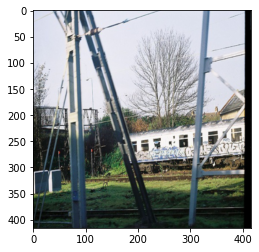

torch.Size([1, 3, 13, 13, 25]) torch.Size([1, 3, 26, 26, 25]) torch.Size([1, 3, 52, 52, 25])


In [152]:
for x , y in dataloader:
    show_tensor_images(x)
    print(y[0].shape , y[1].shape , y[2].shape)
    break

In [157]:
loss_fn = IOU_Loss().to(device)
for x , y in dataloader:
    y0, y1, y2 = (
        y[0].to(device),
        y[1].to(device),
        y[2].to(device),
    )
    out = yolo(x)
    print(out[0].shape , y[0].shape)
    break

loss = (
    loss_fn(out[0][... , :4].squeeze(0), y0[... , :4].squeeze(0))
    + loss_fn(out[1][... , :4].squeeze(0), y1[... , :4].squeeze(0))
    + loss_fn(out[2][... , :4].squeeze(0), y2[... , :4].squeeze(0))
)
print(loss)

torch.Size([1, 3, 13, 13, 25]) torch.Size([1, 3, 13, 13, 25])
tensor(10647., grad_fn=<AddBackward0>)


In [149]:
yolo = YOLO().to(device)
lr = 0.002
betas = (0.5 , 0.999)
opt = torch.optim.Adam(yolo.parameters() , lr=lr , betas = betas)
epochs = 200
display_steps = 1
l1_criterion = nn.L1Loss()

In [170]:
def train():
    mean_yolo_loss = 0
    cur_step = 0

    for epoch in range(epochs):
        for x , y in tqdm(dataloader):
            x = x.to(device)
            y0, y1, y2 = (
                y[0].to(device),
                y[1].to(device),
                y[2].to(device),)

            opt.zero_grad()
            out = yolo(x)
            loss = (
                loss_fn(out[0][... , :4].squeeze(0), y0[... , :4].squeeze(0))
                + loss_fn(out[1][... , :4].squeeze(0), y1[... , :4].squeeze(0))
                + loss_fn(out[2][... , :4].squeeze(0), y2[... , :4].squeeze(0))
            )
            loss_classes = (
                l1_criterion(out[0][... , 5:].squeeze(0) , y0[... , 5:].squeeze(0)
                             + l1_criterion(out[1][... , 5:].squeeze(0) , y1[... , 5:].squeeze(0))
                             + l1_criterion(out[2][... , 5:].squeeze(0) , y2[... , 5:].squeeze(0)))
            )
            loss += loss_classes
            loss.backward()
            opt.step()
            
            mean_yolo_loss += loss.item() / display_steps
            if cur_step % display_steps == 0:
                print(f'Epoch {epoch} , Step {cur_step} , Mean YOLO Loss {mean_yolo_loss}')
            cur_step +=1
        mean_yolo_loss = 0

In [ ]:
train()